# 5. Entity Linking

In [5]:
%run __init__.py

## Defining the entity linking class

In [6]:
import json
import requests


WIKIDATA_BASE = "https://www.wikidata.org/w"

class WikidataEntityLinker():
    def __init__(self, user, passwd):
        pass
    
    def fit(self, X, y, *args):
        return self
    
    def transform(self, X, y, *args):
        return [self.link_entity(entity) 
                for doc in X
                for entity in doc]
    
    def link_entity(self, entity_label):
        url = f"{WIKIDATA_BASE}/api.php?action=wbsearchentities&search=" + \
            f"{entity_label}&language=en&format=json"
        response = requests.get(url)
        if response.status_code != 200:
            raise Error()
        content = json.loads(response.text)
        search_results = content['search']
        if len(search_results) == 0:
            return (entity_label, None)
        return (entity_label, search_results[0]['concepturi'])


In [7]:
entity_linker = WikidataEntityLinker("", "")
res = entity_linker.link_entity('agroforestry')
res

('agroforestry', 'http://www.wikidata.org/entity/Q397350')

## Linking each topic's term to Wikidata

In [8]:
import dill as pickle

# see https://stackoverflow.com/questions/42960637/python-3-5-dill-pickling-unpickling-on-different-servers-keyerror-classtype
pickle._dill._reverse_typemap['ClassType'] = type

def load_object(output_path):
    with open(output_path, 'rb') as file:
        res = pickle.load(file)
    return res

In [9]:
NOTEBOOK_RESULTS_DIR = os.path.join(RESULTS_DIR, '3_topic_modeling')
lda_agriculture_pipe_filename = "agriculture_lda_model.pkl"
dtm_tf_filename = "agriculture_dtm_tf.pkl"

lda_pipe = load_object(os.path.join(NOTEBOOK_RESULTS_DIR, lda_agriculture_pipe_filename))
dtm_tf = load_object(os.path.join(NOTEBOOK_RESULTS_DIR, dtm_tf_filename))

In [10]:
from src.utils import get_topic_terms_by_relevance

def link_topic_terms(entity_linker, model, vectorizer,
                     dtm_tf, n_top_words, lambda_=0.6):
    res = []
    topic_terms = get_topic_terms_by_relevance(model, vectorizer, dtm_tf,
                                               n_top_words, lambda_)
    return [[entity_linker.link_entity(entity) for entity in topic]
            for topic in topic_terms]


In [11]:
linked_terms = link_topic_terms(entity_linker, lda_pipe.named_steps['model'],
                                lda_pipe.named_steps['vectorizer'], dtm_tf, 
                                n_top_words=10, lambda_=0.75)

In [12]:
linked_terms[2]

[('base', 'http://www.wikidata.org/entity/Q191360'),
 ('sensor', 'http://www.wikidata.org/entity/Q167676'),
 ('system', 'http://www.wikidata.org/entity/Q58778'),
 ('node', 'http://www.wikidata.org/entity/Q756100'),
 ('agricultural', 'http://www.wikidata.org/entity/Q5356428'),
 ('breeding', 'http://www.wikidata.org/entity/Q227675'),
 ('technology', 'http://www.wikidata.org/entity/Q11016'),
 ('farming', 'http://www.wikidata.org/entity/Q11451'),
 ('power', 'http://www.wikidata.org/entity/Q25107'),
 ('iot', 'http://www.wikidata.org/entity/Q251212')]

## Topic labelling

In [13]:
import functools
import pdb

from dataclasses import dataclass

import networkx as nx


WIKIDATA_PROPS_EXPAND = ['P31', 'P279', 'P910', 'P2579']


def empty_if_keyerror(function):
    """
    A decorator that wraps the passed in function and
    returns an empty string if a key error is raised.
    """
    @functools.wraps(function)
    def wrapper(*args, **kwargs):
        try:
            return function(*args, **kwargs)
        except KeyError:
            return ""
    return wrapper

def _build_uri(entity_id):
    return f"http://www.wikidata.org/entity/{entity_id}"

@empty_if_keyerror
def _get_aliases(entity_info, lang='en'):
    return [alias['value'] 
            for alias in entity_info['aliases'][lang]]

@empty_if_keyerror
def _get_desc(entity_info, lang='en'):
    return entity_info['descriptions'][lang]['value']

@empty_if_keyerror
def _get_labels(entity_info, lang='en'):
    return entity_info['labels'][lang]['value']


@dataclass
class WikidataNode():
    label: str
    uri: str
    desc: str
    alias: str
        
    def __hash__(self):
        return hash(self.uri)
    
    def to_json(self):
        return {
            'label': self.label
        }


class WikidataGraphBuilder():
    def __init__(self, max_hops=2, additional_props=None):
        self.max_hops = max_hops
        self.props_to_expand = WIKIDATA_PROPS_EXPAND
        if additional_props:
            self.props_to_expand += additional_props
    
    def build_graph(self, topic):
        G = nx.Graph()
        for term in topic:
            term_uri = term[1]
            term_id = term_uri.split('/')[-1]
            self._add_wd_node_info(G, term_id, 0)
        return G
    
    def _add_wd_node_info(self, graph, term_id, curr_hop):
        print(f"Visiting entity '{term_id}' - Curr hop: {curr_hop}")
        if curr_hop > self.max_hops:
            return
        
        # call wikidata API for uri
        endpoint = f"{WIKIDATA_BASE}/api.php?action=wbgetentities&ids={term_id}&languages=en&format=json"
        res = requests.get(endpoint)
        if res.status_code != 200:
            raise Error()
        
        content = json.loads(res.text)
        entity_info = content['entities'][term_id]
        new_node = WikidataNode(_get_labels(entity_info), _build_uri(term_id),
                                _get_desc(entity_info), _get_aliases(entity_info))
        graph.add_node(new_node, id=new_node.uri)
        
        for claim_key, claim_values in entity_info['claims'].items():
            if claim_key not in self.props_to_expand:
                continue
            
            for value in claim_values:
                snaktype = value['mainsnak']['snaktype']
                if snaktype in ['novalue', 'somevalue']:
                    continue
                
                new_node_id = value['mainsnak']['datavalue']['value']['id']
                self._add_wd_node_info(graph, new_node_id, curr_hop + 1)


In [14]:
graph_builder = WikidataGraphBuilder()
subgraph = graph_builder.build_graph(linked_terms[2])

Visiting entity 'Q191360' - Curr hop: 0
Visiting entity 'Q811679' - Curr hop: 1
Visiting entity 'Q391414' - Curr hop: 2
Visiting entity 'Q19603939' - Curr hop: 3
Visiting entity 'Q3955017' - Curr hop: 3
Visiting entity 'Q6477453' - Curr hop: 3
Visiting entity 'Q9149869' - Curr hop: 2
Visiting entity 'Q4167836' - Curr hop: 3
Visiting entity 'Q8970514' - Curr hop: 1
Visiting entity 'Q4167836' - Curr hop: 2
Visiting entity 'Q12139612' - Curr hop: 3
Visiting entity 'Q17442446' - Curr hop: 3
Visiting entity 'Q35252665' - Curr hop: 3
Visiting entity 'Q2944534' - Curr hop: 3
Visiting entity 'Q811430' - Curr hop: 1
Visiting entity 'Q35145743' - Curr hop: 2
Visiting entity 'Q6581281' - Curr hop: 3
Visiting entity 'Q27096235' - Curr hop: 3
Visiting entity 'Q618123' - Curr hop: 3
Visiting entity 'Q6671777' - Curr hop: 2
Visiting entity 'Q35120' - Curr hop: 3
Visiting entity 'Q6643007' - Curr hop: 3
Visiting entity 'Q386724' - Curr hop: 2
Visiting entity 'Q15401930' - Curr hop: 3
Visiting entity '

Visiting entity 'Q10096899' - Curr hop: 3
Visiting entity 'Q61788060' - Curr hop: 3
Visiting entity 'Q6895266' - Curr hop: 1
Visiting entity 'Q4167836' - Curr hop: 2
Visiting entity 'Q12139612' - Curr hop: 3
Visiting entity 'Q17442446' - Curr hop: 3
Visiting entity 'Q35252665' - Curr hop: 3
Visiting entity 'Q2944534' - Curr hop: 3
Visiting entity 'Q11016' - Curr hop: 0
Visiting entity 'Q28797' - Curr hop: 1
Visiting entity 'Q336' - Curr hop: 2
Visiting entity 'Q11862829' - Curr hop: 3
Visiting entity 'Q1458083' - Curr hop: 3
Visiting entity 'Q11862829' - Curr hop: 3
Visiting entity 'Q8917068' - Curr hop: 2
Visiting entity 'Q4167836' - Curr hop: 3
Visiting entity 'Q4884546' - Curr hop: 1
Visiting entity 'Q59541917' - Curr hop: 2
Visiting entity 'Q4167836' - Curr hop: 3
Visiting entity 'Q11862829' - Curr hop: 1
Visiting entity 'Q1047113' - Curr hop: 2
Visiting entity 'Q5962346' - Curr hop: 3
Visiting entity 'Q24017414' - Curr hop: 3
Visiting entity 'Q18329108' - Curr hop: 3
Visiting enti

Visiting entity 'Q59541917' - Curr hop: 3
Visiting entity 'Q816264' - Curr hop: 2
Visiting entity 'Q7469326' - Curr hop: 3
Visiting entity 'Q2465832' - Curr hop: 3
Visiting entity 'Q475023' - Curr hop: 3
Visiting entity 'Q11862829' - Curr hop: 2
Visiting entity 'Q1047113' - Curr hop: 3
Visiting entity 'Q6642719' - Curr hop: 3
Visiting entity 'Q24017414' - Curr hop: 3
Visiting entity 'Q4671286' - Curr hop: 2
Visiting entity 'Q11862829' - Curr hop: 3


In [20]:
import ipycytoscape
import ipywidgets as widgets

undirected = ipycytoscape.CytoscapeWidget()
undirected.graph.add_graph_from_networkx(subgraph)
undirected

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

DEBUG:matplotlib:CONFIGDIR=/home/alejandro/.config/matplotlib
DEBUG:matplotlib:(private) matplotlib data path: /home/alejandro/.envs/edma/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/alejandro/.envs/edma/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/alejandro/.envs/edma/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.2.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', '_vir

DEBUG:matplotlib:CACHEDIR=/home/alejandro/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/alejandro/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


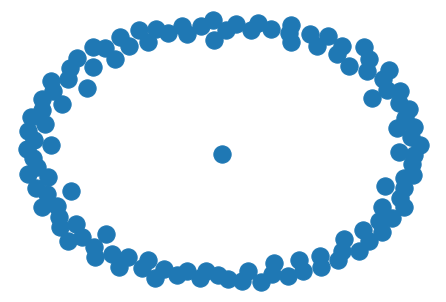

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

nx.draw(subgraph)
plt.show()